# Encoder Decoder

## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from dataset_creation.ImageCreation import ImageCreation

PyTorch version: 2.1.0+cu121


In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
WIDTH, HEIGHT = 32, 32
STROKE_SIZE = 3
IMAGE_FACTOR = 1.1
EPOCHS: int = 20
BATCH_SIZE: int = 3

In [4]:
resources_folder = 'resources/sketchrnn'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)
class_size = {}

data = []

for class_name in classes:
    data_class = np.load(os.path.join(resources_folder, 'sketchrnn_' + class_name + '.npz'), allow_pickle=True, encoding="latin1")

    class_size[class_name] = len(data_class)
    data.append(data_class)

print(f'loaded numpy bitmaps, {nb_classes} classes')
print(len(data))
print(data[0].keys())
print(len(data[0]['train']))
print(len(data[0]['valid']))
print(len(data[0]['test']))

loaded numpy bitmaps, 8 classes
8
KeysView(NpzFile 'resources/sketchrnn/sketchrnn_apple.npz' with keys: test, train, valid)
70000
2500
2500


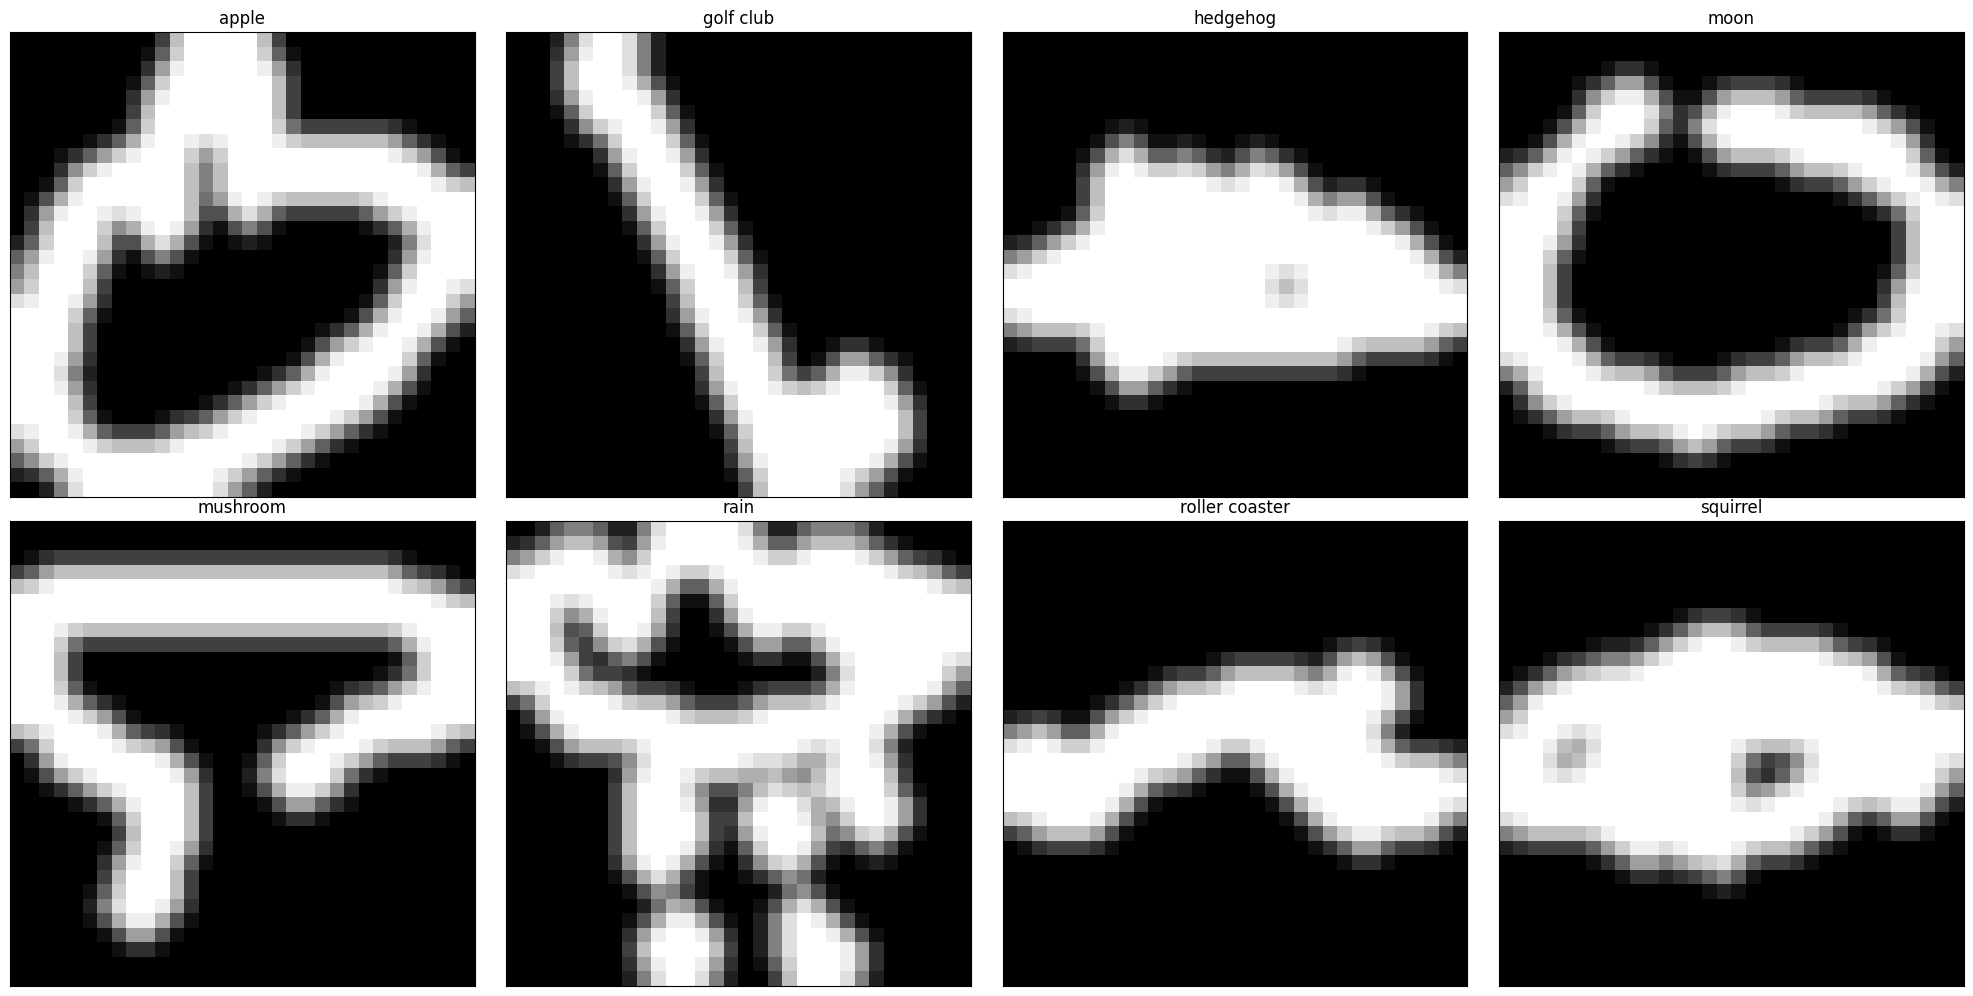

In [5]:
numb_rows = 2
numb_cols = 4

fig, axes = plt.subplots(numb_rows, numb_cols, figsize=(5*numb_cols, 5*numb_rows))
for i in range(nb_classes):
    index = random.randint(0, class_size[classes[i]])
    ax = axes[i//numb_cols, i%numb_cols]
    ax.imshow(ImageCreation.createImage(data[i]["train"][index], (WIDTH, HEIGHT), STROKE_SIZE, IMAGE_FACTOR), cmap='gray')
    ax.set_title(classes[i])

    # no ticks
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.show()

## Dataset creation

In [6]:
from dataset_creation.DataManagerNpz import DataManagerNpz

data_manager = DataManagerNpz()

training_data, training_labels, validation_data, validation_labels, test_data, test_labels = data_manager.parse_data(data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')
print(f'test dataset size : {len(test_data)}') 

training dataset size : 560000
validation dataset size : 20000
test dataset size : 20000


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

shuffled_test_data, shuffled_test_labels = data_manager.shuffle_dataset(test_data, test_labels)

In [8]:
from dataset_creation.StrokeImageDataset import StrokeImageDataset

len_subset = 2000
valid_test_subset = 500

training_set = StrokeImageDataset(
        data=shuffled_training_data[:len_subset], 
        labels=shuffled_training_labels[:len_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=False, normalize=True)

validation_set = StrokeImageDataset(
        data=shuffled_validation_data[:valid_test_subset], 
        labels=shuffled_validation_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=False, normalize=True)

test_set = StrokeImageDataset(
        data=shuffled_test_data[:valid_test_subset], 
        labels=shuffled_test_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=False, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)
test_loaded_set = DataLoader(test_set, batch_size=BATCH_SIZE , shuffle=True)

In [9]:
def dataset_distribution(classes, dataset):
    distrib = {i: 0 for i in range(len(classes))}

    for i in range(dataset.__len__()):
        _, label = dataset.__getitem__(i)
        distrib[label]+=1

    return distrib

In [10]:
print(f'training set distribution :\n{dataset_distribution(classes, training_set)}')
print(f'validation set distribution :\n{dataset_distribution(classes, validation_set)}')
print(f'test set distribution :\n{dataset_distribution(classes, test_set)}')

training set distribution :
{0: 243, 1: 240, 2: 264, 3: 252, 4: 256, 5: 278, 6: 228, 7: 239}
validation set distribution :
{0: 58, 1: 67, 2: 71, 3: 71, 4: 62, 5: 67, 6: 48, 7: 56}
test set distribution :
{0: 72, 1: 65, 2: 61, 3: 54, 4: 54, 5: 73, 6: 59, 7: 62}


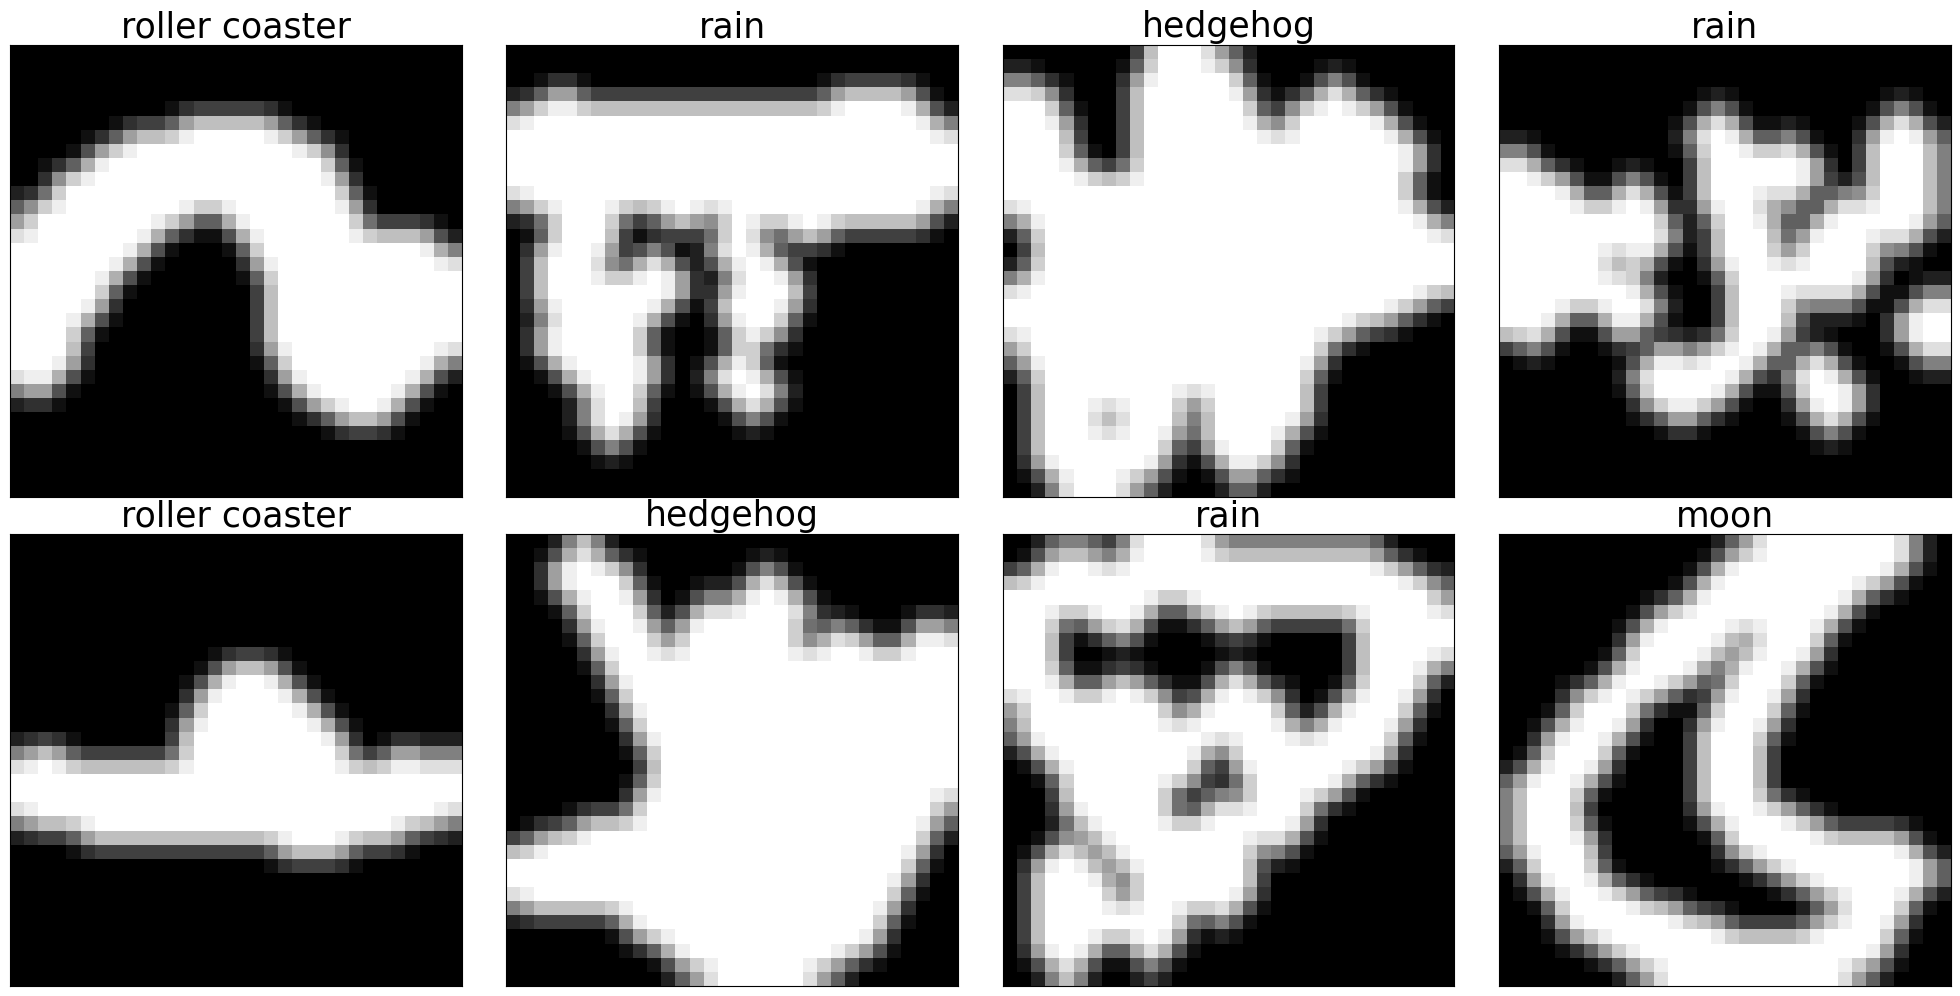

In [11]:
# Show some images
numb_rows = 2
numb_cols = 4

fig, axes = plt.subplots(numb_rows, numb_cols, figsize=(5*numb_cols, 5*numb_rows))
for i in range(numb_rows*numb_cols):
    index = random.randint(0, len(training_set)-1)
    ax = axes[i//numb_cols, i%numb_cols]

    img, label_index = training_set[index]

    ax.imshow(training_set.convert_to_img(img), cmap='gray')
    ax.set_title(classes[label_index], fontsize=25)

    # no ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

## Variational Autoencoder class

In [12]:
from src.linear_variational_autoencoder import LinearVariationalAutoencoder

## Try with simple model

In [13]:
architecture_1 = [WIDTH * HEIGHT, WIDTH * HEIGHT * 3 // 4]
autoencoder_model = LinearVariationalAutoencoder(architecture_1, device, WIDTH, HEIGHT, classes, dropout=0.4, batch_norm=True,
                                                    rl=0.7, kl=0.3)
autoencoder_model.to(device)

# Define loss function and optimizer
criterion = autoencoder_model.vae_loss
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.0001)

In [14]:
# Print architecture 
autoencoder_model.print_model()

nb_params = sum(p.numel() for p in autoencoder_model.parameters() if p.requires_grad)
print("Nb params", nb_params)

# Compression factor 
print(f'Compression factor: {(len(architecture_1)-2)*2}')

Sequential()
Linear(in_features=1024, out_features=768, bias=True)
Linear(in_features=1024, out_features=768, bias=True)
Sequential(
  (decoder_1): Linear(in_features=768, out_features=1024, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Nb params 2361856
Compression factor: 0


In [15]:
def tensor_to_numpy(tensor):
    return tensor.cpu().detach().numpy()

def tensor_to_img(tensor):
    return tensor_to_numpy(tensor).reshape((WIDTH, HEIGHT))

In [16]:
# Call the function
num_epochs = 50
autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, 
                                    optimizer, criterion=criterion, num_epochs=num_epochs)

Ep [1/50] T L: 118.3204 T KL L: 79.5453 T KL L: 38.7751 V L: 151.6800 V RL L: 116.3800 V KL L: 35.3000 T PSNR: 11.4000 T SSIM: 0.2500 V PSNR: 11.3300 V SSIM: 0.2500
Ep [2/50] T L: 92.0685 T KL L: 53.9464 T KL L: 38.1221 V L: 87.6000 V RL L: 52.0200 V KL L: 35.5900 T PSNR: 13.1200 T SSIM: 0.3500 V PSNR: 13.0100 V SSIM: 0.3400
Ep [3/50] T L: 68.4351 T KL L: 40.8565 T KL L: 27.5786 V L: 98.1500 V RL L: 70.8900 V KL L: 27.2600 T PSNR: 14.0600 T SSIM: 0.3900 V PSNR: 13.8800 V SSIM: 0.3800
Ep [4/50] T L: 64.3913 T KL L: 33.3194 T KL L: 31.0719 V L: 68.0600 V RL L: 37.3600 V KL L: 30.7000 T PSNR: 15.1200 T SSIM: 0.4300 V PSNR: 14.9100 V SSIM: 0.4200
Ep [5/50] T L: 63.3282 T KL L: 32.0364 T KL L: 31.2918 V L: 51.2600 V RL L: 27.5100 V KL L: 23.7500 T PSNR: 15.8300 T SSIM: 0.4600 V PSNR: 15.5400 V SSIM: 0.4500
Ep [6/50] T L: 61.1023 T KL L: 33.4313 T KL L: 27.6710 V L: 48.4300 V RL L: 23.8100 V KL L: 24.6300 T PSNR: 16.5000 T SSIM: 0.4800 V PSNR: 16.2100 V SSIM: 0.4700
Ep [7/50] T L: 52.8876 T 

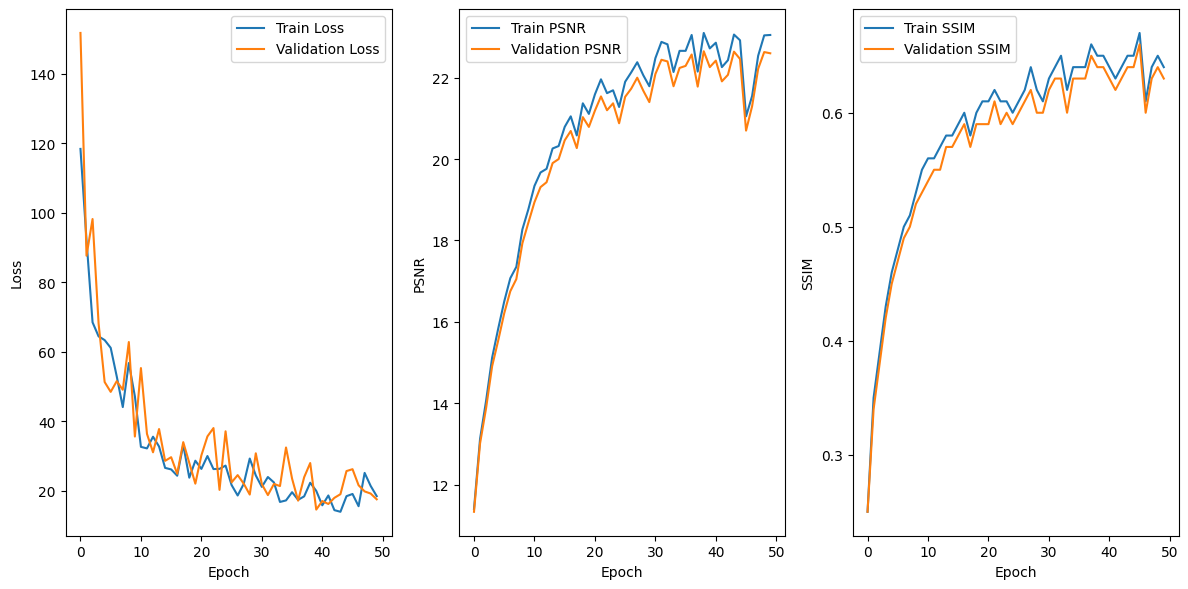

In [17]:
autoencoder_model.plot_psnr_ssim()

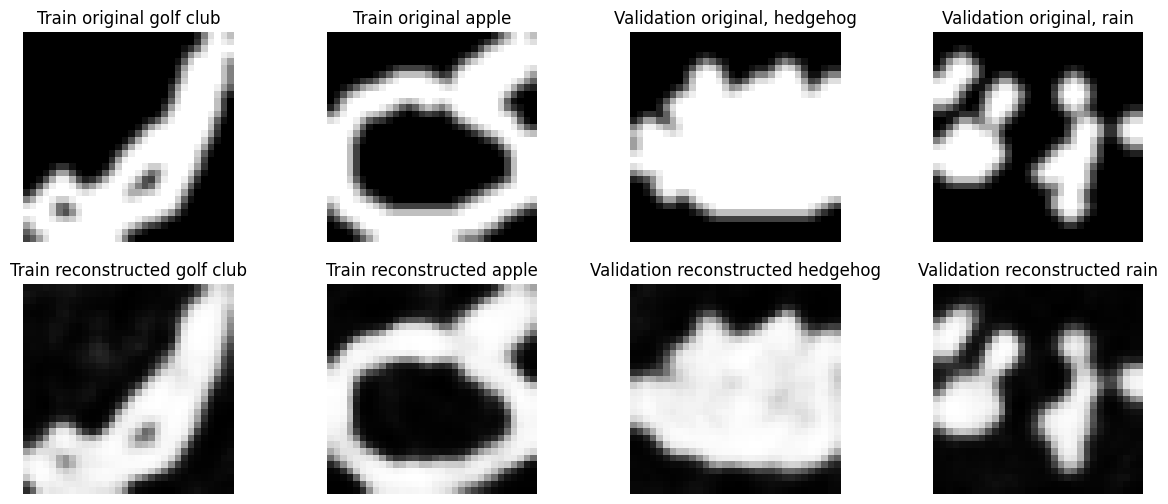

In [18]:
autoencoder_model.show_images(training_set, validation_set)

In [19]:
CHECK_BACTH_SIZE = 8000

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [20]:
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

Lowest PSNR index: 102|17.4646902006287, Lowest SSIM index: 152|0.3014035470667524


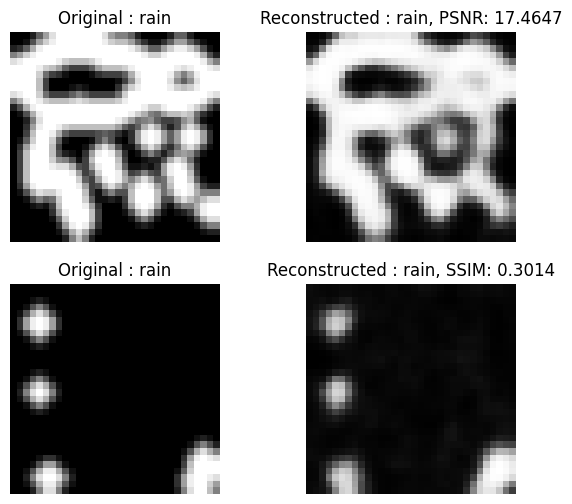

In [21]:
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

In [22]:
from sklearn.decomposition import PCA

def latent_space_visualization(model, valid_loader):
    model.eval()
    pca = PCA(n_components=2)

    points = []
    label_idcs = []
    for data in valid_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
            
        mu, sigma, z, decoded = model(inputs)
        for i in range(inputs.size(0)):
            proj = z
            points.append(tensor_to_numpy(proj[i]))
            label_idcs.append(labels[i].detach().cpu().numpy())
    points = np.array(points)
    points = pca.fit_transform(points)
    
    # Creating a scatter plot
    fig, ax = plt.subplots(figsize=(10, 10))
    scatter = ax.scatter(x=points[:, 0], y=points[:, 1], s=2.0, c=label_idcs, cmap='tab10', alpha=0.9, zorder=2)

    ax.grid(True, color="lightgray", alpha=1.0, zorder=0)

    plt.legend(*scatter.legend_elements(), loc="lower right", title="Classes")
    plt.show()

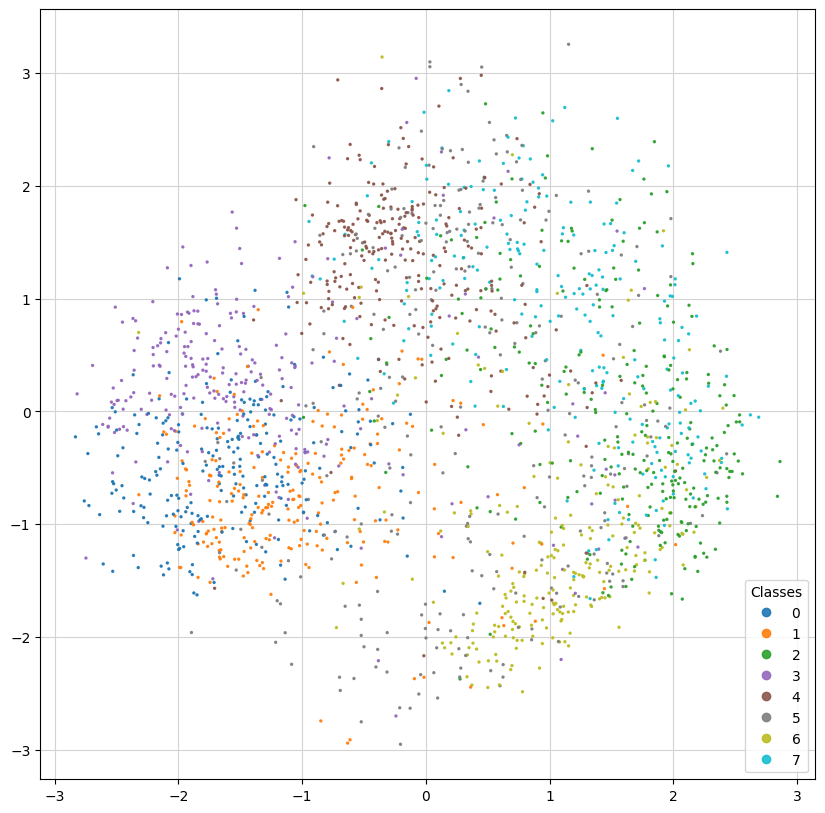

In [27]:
latent_space_visualization(autoencoder_model, training_loaded_set)

## Generating images

In [24]:
from src.generator import ImageGenerator

image_generator = ImageGenerator(classes, device, autoencoder_model)

Class apple range of mean encoded vector: [-0.2514821683006829, 0.28538695132214226]
Class golf club range of mean encoded vector: [-0.27008825421410926, 0.28055618604800353]
Class hedgehog range of mean encoded vector: [-0.24394307706406285, 0.22385281270059446]
Class moon range of mean encoded vector: [-0.17522668099356076, 0.18532110879655986]
Class mushroom range of mean encoded vector: [-0.22494272608673782, 0.23914744408830302]
Class rain range of mean encoded vector: [-0.15081912408107154, 0.1871717362413384]
Class roller coaster range of mean encoded vector: [-0.23671833426985694, 0.2240640212610168]
Class squirrel range of mean encoded vector: [-0.1928767744903784, 0.18753569004628573]


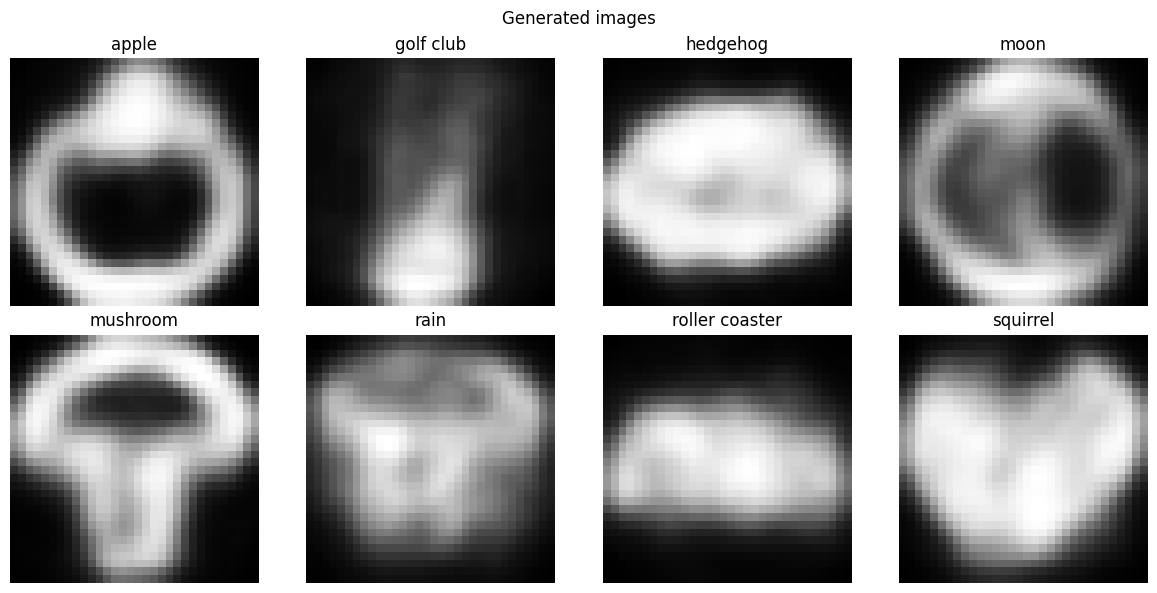

In [25]:
mean_encoded_vectors = image_generator.generate_mean_encoded_vectors_per_classes(training_loaded_set, conv_model=False)
image_generator.show_generated_images_per_mean_vectors(mean_encoded_vectors, image_size=(WIDTH, HEIGHT))

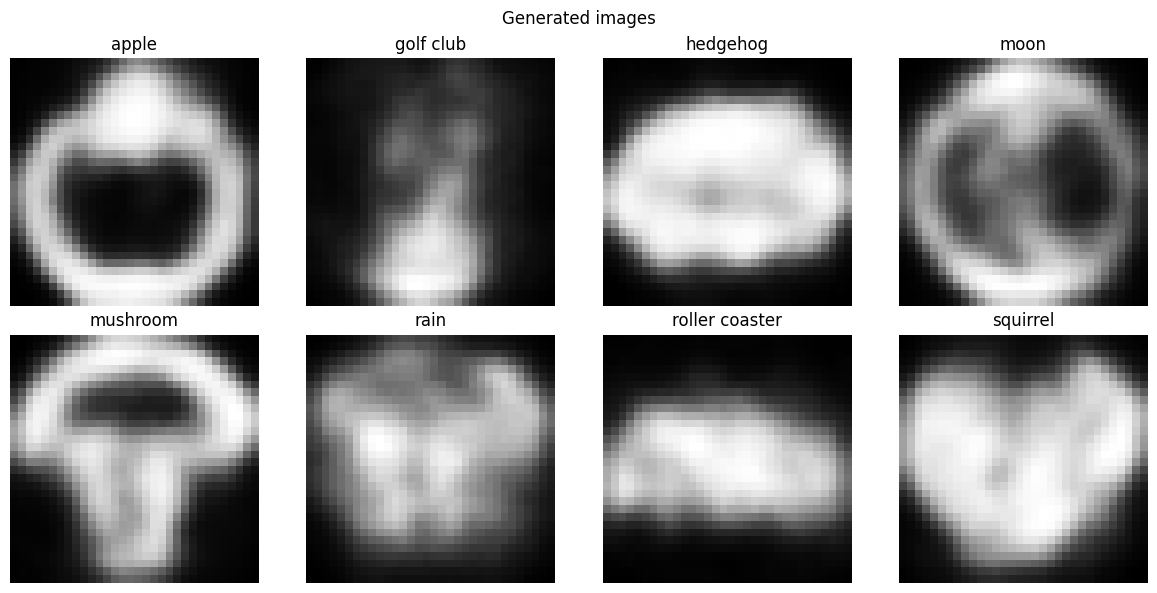

In [26]:
noised_encoded_vectors = image_generator.generate_noised_mean_vectors(mean_encoded_vectors, 0.05)
image_generator.show_generated_images_per_mean_vectors(noised_encoded_vectors, image_size=(WIDTH, HEIGHT))